In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels import api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

# Telco Customer Churn

## Context  
Telco merupakan sebuah company yang bergerak di bidang Internet Service Provider. Pada dataset yang diberikan, terdapat data-data customer dari perusahaan tersebut. Data-data ini merepresentasikan sebuah customer profile yang memakai jasa apa saja dari perusahaan tersebut, yang pada akhirnya di kategorikan sebagai **Churn** atau **Not Churn**.

**Churn** dan **Not Churn** disini merupakan sebuah situasi yang mengambarkan apakah seorang customer telah berhenti memakai jasa perusahaan tersebut, dengan **Churn** adalah kategori dimana customer itu berhenti, dan **Not Churn** adalah kategori dimana customer tersebut masih memakai jasa perusahaan tersebut.

Target :  
**Churn** : Berhenti memakai jasa perusahaan  
**Not Churn** : Tidak berhenti memakai jasa perusahaan

**Problem Statement :**

Sebuah kesuksesan sebuah perusahaan, terutama pada perusahaan jasa, dapat dilihat dari berapa banyak orang yang memakai jasa perusahaan tersebut. Jika seorang customer memutuskan untuk  berhenti mamakai jasa perusahaan (**Churn**), maka hal ini akan berdampak negatif bagi perusahaan karena perusahaan akan kehilangan source of income. Akan tetapi, sesukses apapun perusahaan tersebut, kehilangan customer merupakan hal yang tidak bisa dihindari karena ada banyaknya faktor yang mempengaruhi seorang customer akan setia memakai jasa perusahaan atau tidak. Maka dari itu, selain dari perusahaan tetap harus improve jasa mereka agar customer nyaman dan bahagia menggunakan jasa perusahaan, perusahaan juga harus dapat memprediksi apakah seorang customer akan senantiasa memakai jasa perusahaan atau tidak, agar perusahaan tetap siap dalam menghadapi kondisi seperti itu.

Kita sebagai Data Analyst diminta perusahaan ini untuk membuatkan sebuah model yang dapat memprediksi apakah seorang customer akan **Churn** atau tidak.

**Goals :**

Maka berdasarkan permasalahan tersebut, perusahaan ingin memiliki kemampuan untuk memprediksi apakah seorang customer akan **Churn** dari jasa perusahaan atau tidak, sehingga dapat meminimalisir kerugian yang ditimbulkan dari customer yang **Churn** tersebut.

Selain dari model, kita juga dapat diharapkan untuk dapat mengetahui faktor-faktor apa saja yang paling mempengaruhi seorang customer akan **Churn** atau tidak.

**Metric Evaluation :**

Type 1 error : False Positive (kondisi dimana kita memprediksi ketagori positive, tetapi actualnya adalah negative)  
Konsekuensi : Kita bisa mengalami kekurangan sumber daya karena banyaknya customer dari customer **Not Churn** False Positive tersebut dan potential new customer.

Type 2 error : False Negative  (kondisi dimana kita memprediksi ketagori negative, tetapi actualnya adalah positive)  
Konsekuensi : Kita akan mengalami kerugian karena kehilangan source of income yang sudah kita prediksikan dari customer False Negative tersebut.

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi kerugian karena kehilangan source of income tersebut. Jadi kita ingin model kita dapat memprediksi kelas negative dengan tepat, agar nilai false negative menjadi seminimal mungkin. Dengan demikian metric utama yang akan kita gunakan adalah recall.

## Data Understanding and Cleaning

Dataset source : https://drive.google.com/drive/folders/1_fR7R0srpZgnFnanbrmELgnK-xmzMAHp

Pertama, mari kita lihat informasi umum dari dataset ini.

In [2]:
# Load Dataset
df=pd.read_csv('data_telco_customer_churn.csv')
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [3]:
# Lihat Unique Value dan berapa jumlah Unique Value
listItem = []

for col in df.columns:
    listItem.append([col,df[col].nunique(),df[col].unique()])

table = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],data=listItem)
table

,Column Name,Number of Unique,Unique Sample
0,Dependents,2,"[Yes, No]"
1,tenure,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1..."
2,OnlineSecurity,3,"[No, Yes, No internet service]"
3,OnlineBackup,3,"[No, Yes, No internet service]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,3,"[Yes, No internet service, No]"
6,TechSupport,3,"[Yes, No, No internet service]"
7,Contract,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,2,"[Yes, No]"
9,MonthlyCharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7,..."


In [4]:
# General Information
df.describe(include='all')

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
count,4930,4930.000000,4930,4930,4930,4930,4930,4930,4930,4930.000000,4930
unique,2,NaN,3,3,3,3,3,3,2,NaN,2
top,No,NaN,No,No,Fiber optic,No,No,Month-to-month,Yes,NaN,No
freq,3446,NaN,2445,2172,2172,2186,2467,2721,2957,NaN,3614
mean,NaN,32.401217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.883032,NaN
std,NaN,24.501193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.923960,NaN
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.800000,NaN
25%,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.050000,NaN
50%,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [5]:
# General Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [6]:
# Lihat Missing Value
df.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [7]:
# Lihat Duplicate Value
df.duplicated().sum()

77

In [8]:
# Drop Duplicate Value
df=df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
# Melihat apakah datanya balance dan imbalance
df['Churn'].value_counts(normalize='index')

No     0.734597
Yes    0.265403
Name: Churn, dtype: float64

<AxesSubplot:ylabel='Churn'>

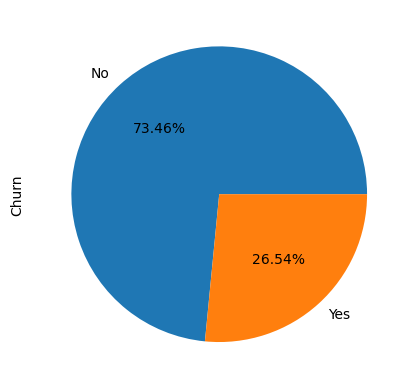

In [10]:
# Visualisasi apakah datanya balance dan imbalance
df['Churn'].value_counts(normalize='index').plot(kind='pie',y='churn',autopct='%1.2f%%')

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

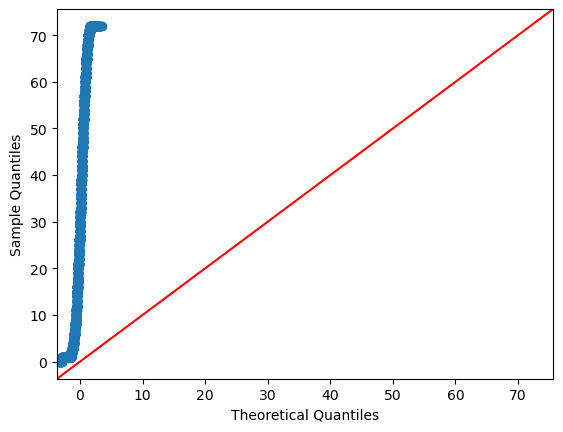

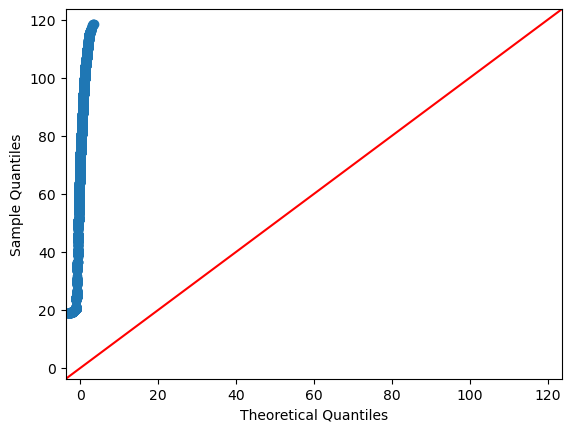

In [11]:
# Cek Distribusi feature numerikal
sm.qqplot(df['tenure'],line='45'),sm.qqplot(df['MonthlyCharges'],line='45')

In [12]:
# Mengubah kategoti target menjadi 1 dan 0
df['Churn']=df['Churn'].map({'Yes':1,'No':0}).astype(int)

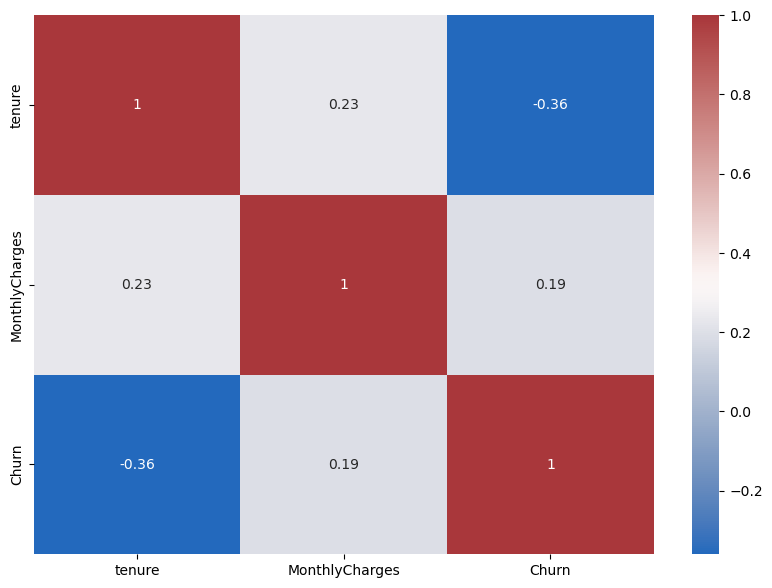

In [13]:
# Melihat Correlation dari data numerikal dengan target
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),cmap='vlag',annot=True)
plt.show()

1. Dataset tidak seimbang, dengan persentase customer yang churn adalah 26,54%
2. Feature Dependents, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport, Contract, dan PaperlessBilling merupakan feature kategorikal.
3. Feature Tenure dan MonthlyCharges merupakan feature numerical.
4. Distribusi dari Tenure dan MonthlyCharges tidak normal.
5. Berikut penjelasan singkat mengenai feature-feature tersebut:
    - Dependents : Apakah customer memiliki tanggungan atau tidak.
    - Tenure : Jumlah bulan customer memakai jasa perusahaan.
    - OnlineSecurity : Apakah customer memiliki keamanan online atau tidak.
    - OnlineBackup : Apakah customer memiliki cadangan online atau tidak.
    - InternetService : Apakah customer berlangganan layanan Internet.
    - DeviceProtection : Apakah customer memiliki perlindungan perangkat atau tidak.
    - TechSupport : Apakah customer memiliki dukungan teknis atau tidak.
    - Contract : Jenis kontrak menurut durasi.
    - PaperlessBilling : Tagihan diterbitkan dalam bentuk tanpa kertas.
    - MonthlyCharges : Jumlah biaya untuk layanan pada basis bulanan.
    - Churn : Apakah pelanggan melakukan churn atau tidak.
6. Tidak terdapat missing value pada dataset kita.
7. Terdapat 77 duplicates data, kita akan drop saja karena data terebut hanya 1% dari total data kita.

In [14]:
# Mengdefinisikan feature dan target
x=df.drop(columns=['Churn'])
y=df['Churn']

In [15]:
# Split menjadi data train dan test
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=2023,stratify=y,test_size=0.2)

In [16]:
# Pendefinisian Encoder dan Scaler
transformer=ColumnTransformer([
    ('Encoding',OneHotEncoder(drop='first'),['Dependents','OnlineSecurity','OnlineBackup','InternetService','DeviceProtection','TechSupport','Contract','PaperlessBilling']),
    ('Scaling',RobustScaler(),['tenure','MonthlyCharges'])
],remainder='passthrough')

In [17]:
# Pendifinisian resampler
ros=RandomOverSampler()
rus=RandomUnderSampler()

In [18]:
# Pendefinisian model
model_log_reg=LogisticRegression(random_state=2023)
model_knn=KNeighborsClassifier()
model_tree=DecisionTreeClassifier(random_state=2023)
model_vc=VotingClassifier([
    ('model1',model_log_reg),
    ('model2',model_knn),
    ('model3',model_tree)
])
model_sc=StackingClassifier([
    ('model1',model_log_reg),
    ('model2',model_knn),
    ('model3',model_tree)
])
model_rf=RandomForestClassifier(random_state=2023)
model_abc=AdaBoostClassifier(random_state=2023)
model_gbc=GradientBoostingClassifier(random_state=2023)

Untuk feature nya, kita akan gunakan seluruh kolom dari data kita kecuali kolom **Churn**, dan targetnya sendiri adalah kolom **Churn** itu sendiri. Lalu kita split data train dan test nya menjadi 80:20. Kita gunakan stratify agar porsi pembagian train dan test nya serupa dgn data aslinya.

Untuk tahap pre-processing, kita akan mengubah seluruh data kategorikal memakai One Hot Encoder karena jumlah pembagian kategori pada feature-feature tersebut tidak terlalu banyak, dimana seluruh feature kategorikal kita hanya mempunyai 2 atau 3 value yg unique saja. Cara kerja One Hot Encoder ini sendiri adalah system akan membuat kolom-kolom baru sesuai dengan jumlah kategorikal yang ada. Isi pada kolom-kolom baru tersebut adalah binary 1 atau 0, dimana ketika kategori suatu kolom tersebut adalah kategori tersebut, maka isinya adalah 1, jika bukan maka isinya adalah 0. Kita gunakan drop='first', untuk drop kolom pertama ketika system membuat kolom-kolom baru tersebut.  
Lalu untuk data numerikal, kita akan mengubahnya dengan Robust Scaler, karena sesuai dari yang kita lihat di atas, distribusi data numerik tersebut tidak normal. Cara kerja Robust Scaler itu sendiri adalah meng-scaling angka-angka berdasarkan quantile range nya, sebab itu Robust Scaler biasa digunakan ketika ada outlier.

Berikutnya, karena data kita imbalance, kata akan melakukan resampling. Metode yang akan kita gunakan ada 2, yaitu Random Over Sampler dan Random Under Sampler.

Untuk modelnya sendiri kita akan mencoba untuk memakai Logistic Regression, K Neighbors Classifier, Decision Tree Classifier, Voting Classifier, Stacking Classifier, Random Forest Classifier, Ada Boost Classifier, dan Gradient Boosting Classifier.

# Benchmarking

In [19]:
# Cross validasi tanpa kita resample
model=[model_log_reg,model_knn,model_tree,model_rf,model_abc,model_gbc,model_vc,model_sc]
score=[]
mean=[]
std=[]

for i in model:
    model_pipeline=Pipeline([
        ('preprocessing',transformer),
        ('modeling',i)
    ])
    model_score=np.round(cross_val_score(model_pipeline,xtrain,ytrain,cv=5,scoring='recall'),2)
    score.append(model_score)
    mean.append(model_score.mean())
    std.append(model_score.std())

normal=pd.DataFrame({
    'Model':['LogReg','Neighbors','Tree','Forest','AdaBoost','GradBoost','Voting','Stacking'],
    'Mean':mean,
    'Deviation':std,
})

C:\Users\Teo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Teo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

In [20]:
# Cross validasi dengan metode Random Over Sampling
model=[model_log_reg,model_knn,model_tree,model_rf,model_abc,model_gbc,model_vc,model_sc]
score_ros=[]
mean_ros=[]
std_ros=[]

for i in model:
    model_pipeline=Pipeline([
        ('preprocessing',transformer),
        ('resampling',ros),
        ('modeling',i)
    ])
    model_score=np.round(cross_val_score(model_pipeline,xtrain,ytrain,cv=5,scoring='recall'),2)
    score_ros.append(model_score)
    mean_ros.append(model_score.mean())
    std_ros.append(model_score.std())

rosdf=pd.DataFrame({
    'Model':['LogReg','Neighbors','Tree','Forest','AdaBoost','GradBoost','Voting','Stacking'],
    'Mean Over Sampling':mean_ros,
    'Deviation Over Sampling':std_ros,
})

C:\Users\Teo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Teo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

In [21]:
# Cross validasi dengan metode Under Over Sampling
model=[model_log_reg,model_knn,model_tree,model_rf,model_abc,model_gbc,model_vc,model_sc]
score_rus=[]
mean_rus=[]
std_rus=[]

for i in model:
    model_pipeline=Pipeline([
        ('preprocessing',transformer),
        ('resampling',rus),
        ('modeling',i)
    ])
    model_score=np.round(cross_val_score(model_pipeline,xtrain,ytrain,cv=5,scoring='recall'),2)
    score_rus.append(model_score)
    mean_rus.append(model_score.mean())
    std_rus.append(model_score.std())

rusdf=pd.DataFrame({
    'Model':['LogReg','Neighbors','Tree','Forest','AdaBoost','GradBoost','Voting','Stacking'],
    'Mean Under Sampling':mean_rus,
    'Deviation Under Sampling':std_rus,
})

C:\Users\Teo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Teo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

In [22]:
# Hasil dari Cross Validation
normal.merge(rosdf,on='Model').merge(rusdf,on='Model')

,Model,Mean,Deviation,Mean Over Sampling,Deviation Over Sampling,Mean Under Sampling,Deviation Under Sampling
0,LogReg,0.508,0.019391,0.788,0.023152,0.788,0.023152
1,Neighbors,0.484,0.026533,0.724,0.042708,0.762,0.023152
2,Tree,0.494,0.044091,0.510,0.041473,0.698,0.032496
3,Forest,0.468,0.024819,0.536,0.030067,0.704,0.025768
4,AdaBoost,0.494,0.020591,0.812,0.026382,0.816,0.023324
5,GradBoost,0.502,0.011662,0.776,0.026533,0.786,0.020591
6,Voting,0.494,0.012000,0.708,0.023152,0.776,0.017436
7,Stacking,0.496,0.020591,0.468,0.061123,0.784,0.025768


Untuk benchmarking kita, kita akan mengimplementasikan pipeline dengan urutan yg pertama adalah tahap pre-processing, yaitu Encoding dan Scaling yang dijadikan satu menggunakan Column Transformer. Lalu yang kedua adalah tahap resampling, dimana pada percobaan pertama kita tidak akan melakukan resampling untuk mencari tahu score awal dari model-model yang telah kita tetapkan, dan baru akan mengimplementasikan resampling pada percobaan kedua dan ketiga. Lalu yang ketiga baru kita lakukan modeling untuk mencari tahu berapa nilai yang kita dapatkan dari model-model tersebut.

Untuk mencari tahu nilai model mana yang terbaik, maka kita gunakan Cross Validation, dimana Cross Validation ini akan membagi data train kita menjadi 2 lagi, yaitu data train for validation dan data validation, yang nantinya akan divalidasi sebanyak yang kita tentukan, dengan metode scoring yang kita gunakan adalah **Recall**.

Jika kita lihat hasilnya, terdapat variasi kenaikan ataupun penurunan nilai score model diatas. Tetapi bisa kita lihat bahwa model Adaptive Boosting Classifier mengalami perubahan yang cukup significant, dari score kurang lebih 0.5 sebelum kita implementasikan resampling, menjadi nilai tertinggi dari semua model, 0.81 dengan resampling method Random Under Sampling.

*Adaptive Boosting Classifier itu sendiri adalah salah satu model ensemble learning similiar type. Cara kerja Adaptive Boosting Classifier adalah model akan train data yg diberikan dan model akan fokus belajar dari kesalahan yg dibuat. Kesalah tersebut akan dijadikan pembelajaran bagi model kita dalam pembuatan next model.*

Kita akan memakai model ini untuk langkah kita selanjutnya, yaitu hypertuning.

# Hyperparameter Tuning

In [23]:
# Predict dengan best model : AdaBoostClassifier, tanpa tuning.
best_model_pipeline=Pipeline([
    ('preprocessing',transformer),
    ('resampling',rus),
    ('modeling',model_abc)
])

best_model_pipeline.fit(xtrain,ytrain)
ypred=best_model_pipeline.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82       713
           1       0.53      0.84      0.65       258

    accuracy                           0.76       971
   macro avg       0.73      0.79      0.73       971
weighted avg       0.82      0.76      0.77       971



In [24]:
# Feature Importances
df_imp = pd.DataFrame({
    'feature': best_model_pipeline['preprocessing'].get_feature_names_out(),
    'importance': best_model_pipeline['modeling'].feature_importances_
})

df_imp.sort_values('importance', ascending=False)

,feature,importance
15,Scaling__MonthlyCharges,0.46
14,Scaling__tenure,0.24
12,Encoding__Contract_Two year,0.08
5,Encoding__InternetService_Fiber optic,0.06
11,Encoding__Contract_One year,0.06
0,Encoding__Dependents_Yes,0.02
2,Encoding__OnlineSecurity_Yes,0.02
4,Encoding__OnlineBackup_Yes,0.02
10,Encoding__TechSupport_Yes,0.02
13,Encoding__PaperlessBilling_Yes,0.02


In [25]:
# Hyperparameter tuning
best_model_pipeline=Pipeline([
    ('preprocessing',transformer),
    ('resampling',rus),
    ('modeling',model_abc)
])

hyperparam={
    'modeling__base_estimator':[LogisticRegression(),DecisionTreeClassifier()],
    'modeling__n_estimators':range(1,16),
    'modeling__learning_rate':np.arange(0.1,0.6,0.1),
    'modeling__algorithm':['SAMME','SAMME.R'],
    'modeling__random_state':[2023],
}

gridsearch=GridSearchCV(estimator=best_model_pipeline,param_grid=hyperparam,cv=5,scoring='recall',n_jobs=-1)
gridsearch.fit(xtrain,ytrain)
best=gridsearch.best_estimator_
best.fit(xtrain,ytrain)
ypred=best.predict(xtest)
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

           0       0.93      0.70      0.80       713
           1       0.51      0.86      0.64       258

    accuracy                           0.74       971
   macro avg       0.72      0.78      0.72       971
weighted avg       0.82      0.74      0.75       971



In [26]:
# Best parameters dari tuning
gridsearch.best_estimator_['modeling']

AdaBoostClassifier(algorithm='SAMME', base_estimator=LogisticRegression(),
                   learning_rate=0.5, n_estimators=8, random_state=2023)

Pertama, mari kita coba predict data test kita tanpa kita tuning terlebih dahulu untuk mengetahui nilai awal dari model kita. Kita masih menggunakan pipeline dimana proses nya adalah preprocessing terlebih dahulu, yaitu One Hot Encoder dan Robust Scaler, dilanjutkan dengan resampling kita, yaitu Random Under Sampler, dan yg terakhir modeling kita, yaitu Adaptive Boosting Classifier. Dapat dilihat bahwa model kita mendapatkan Recall Score nya sebesar 0.83. Hal ini merupakan hal yang baik karena score yang didapat kurang lebih sesuai dengan hasil Cross Validation Score kita.

Sekarang mari kita tuning untuk mengetahui apakah kita dapat meningkatkan score tersebut. Untuk parameter dari Adaptive Boosting Classifier adalah base_estimator, n_estimators, learning_rate, algorithm, dan random_state. Untuk base_estimator, mari kita tambahkan Logistic Regression sebagai base_estimator kita (default adalah Decision Tree Classifier karena ini adalah tree based model). n_estimators disini adalah kita menetukan berapa kali model akan belajar dari model yang sebelumnya, mari kita setting menjadi 1 sampai 15 kali. Untuk learning_rate, ini adalah indikasi seberapa cepat model akan belajar dari kesalahan, untuk value nya kita set dari 0.1 sampai dengan 0.6. Untuk algorithm hanya ada 2 yakni SAMME dan SAMME.R. Untuk random_state bisa diberikan angka berapapu itu.

Untuk mengimplementasikan hypterparameter tuning tersebut, kita gunakan Grid Search CV, dimana pada Grid Search CV, model akan menjalankan semua variasi parameter yg kita tentukan dan mencatat nilai yg paling baik dari seluruh variasi tersebut. Dapat dilihat dari hasil tuning kita bahwa model kita mengalami peningkatan score dari 0.84 menjadi 0.86. Parameter yg digunakan adalah Logistic Regression sebagai base model, algorithm nya adalah 'SAMME', learning_rate nya adalah 0.5, dan n_estimators nya adalah 8.

# CONCLUSION
1. Metric utama yang akan kita gunakan adalah recall, karena kita ingin meminimalisir konsekuensi pada Type 2 error.
2. Berdasarkan Cross Validation, model terbaik yang dapat digunakan adalah Adaptive Boosting Classifier.
3. Berdasarkan pemodelan Adaptive Boosting Classifier yang menggunakan Decision Tree Classifier, fitur/kolom Monthly Charges dan Tenure adalah yang paling penting dan berpengaruh terhadap target (Churn).
4. Berdasarkan hyperparameter tuning, parameter terbaik yang dapat digunakan untuk benchmark model Adaptive Boosting Classifier adalah :
    * base_estimator:LogisticRegression  
    * n_estimators:8  
    * learning_rate:0.5  
    * algorithm:'SAMME'
5. Bila seandainya rata2 biaya seorang Customer memakai jasa perusahaan adalah 50 USD, dan andaikan ada 100 orang Customer, maka hitungannya kurang lebih akan seperti ini:
    * Tanpa Model (semua Customer dianggap tidak akan Churn):
        - Total Income => 100 x 50 USD = 5000 USD
        - Quota for Loss of Income = 0
        - Total Customer yang Churn => 25 orang
        - Total Customer yang tidak Churn => 75 orang
        - Total Loss of Income => 25 x 50 USD = 1250 USD (karena 25 orang Churn yg menyebabkan ada nya)
        - Total Loss => Quota - Loss of Income => 0 - 1250 USD = **-1250 USD**
    * Dengan Model (terdapat prediksi untuk Customer yg akan Churn sehinga ada quota untuk Loss of Income):
        - Total Income => 86 x 50 USD = 4300 USD
        - Quota for Loss of Income = 14 x 50 USD = 700 USD
        - Total Customer yang Churn => 15 orang
        - Total Customer yang tidak Churn => 85 orang
        - Total Loss of Income => 14 x 50 USD = 700 USD
        - Total Loss => Quota - Loss of Income => 700 - 700 USD = **0 USD**

# RECOMMENDATION
1. Memberikan diskon pada MonthlyCharges bagi customer jika memungkinkan, atau memberikan imbalan atau reward yang tidak merugikan perusahaan, agar customer tidak merasa bahwa harganya terlalu mahal.
2. Membuat Customer Loyalty Program yang mendorong customer agar tetap bertahan dan memiliki waktu tenure yang panjang. Bentuk program bisa berupa pemberian reward yang besarannya disesuaikan dengan masa tenure. Semakin panjang tenure, semakin besar reward yang bisa didapat, sehingga mendorong pelanggan untuk memiliki tenure yang lebih panjang.
3. Menambahkan fitur-fitur atau kolom baru yang berisi tingkat kepuasan pelanggan untuk masing-masing layanan, sehingga dapat diketahui lebih lanjut apakah churn disebabkan oleh kualitas layanan yang buruk atau tidak.
4. Karena data kita merupakan data yang imbalance, kita bisa merekomendasikan penambahan data khususnya untuk kelas minoritas (Churn) agar dapat membantu meningkatkan performa model.